In [2]:
#########################################
# 1. IMPORT LIBRARIES & SET GLOBAL VARS #
#########################################

import os
from os.path import exists
import glob
import re
import sys
sys.path.append('../')


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
import xarray as xr

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

# import gdown

# Threshold used for selecting reliable voxels.
NCSNR_THRESHOLD = 0.2


from PIL import Image

from sklearn.manifold import MDS
from sklearn.decomposition import PCA

from sklearn.linear_model import RidgeCV  # using RidgeCV with a fixed alpha
from sklearn.metrics import r2_score as r2_score_sklearn

import sys

import pickle

In [3]:
# Load Algonauts data

with open('../algonauts_brain_data_joint_images_8subjects.pkl', 'rb') as f:
    brainData = pickle.load(f)

shared_images = np.load('../algonauts_joint_images_8subjects.npy')

In [4]:
avail_models = models.list_models(module=torchvision.models)
avail_models

['alexnet',
 'convnext_base',
 'convnext_large',
 'convnext_small',
 'convnext_tiny',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b2',
 'efficientnet_b3',
 'efficientnet_b4',
 'efficientnet_b5',
 'efficientnet_b6',
 'efficientnet_b7',
 'efficientnet_v2_l',
 'efficientnet_v2_m',
 'efficientnet_v2_s',
 'googlenet',
 'inception_v3',
 'maxvit_t',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet_v2',
 'mobilenet_v3_large',
 'mobilenet_v3_small',
 'regnet_x_16gf',
 'regnet_x_1_6gf',
 'regnet_x_32gf',
 'regnet_x_3_2gf',
 'regnet_x_400mf',
 'regnet_x_800mf',
 'regnet_x_8gf',
 'regnet_y_128gf',
 'regnet_y_16gf',
 'regnet_y_1_6gf',
 'regnet_y_32gf',
 'regnet_y_3_2gf',
 'regnet_y_400mf',
 'regnet_y_800mf',
 'regnet_y_8gf',
 'resnet101',
 'resnet152',
 'resnet18',
 'resnet34',
 'resnet50',
 'resnext101_32x8d',
 'resnext101_64x4d',
 'resnext50_32x4d',
 'shufflenet_v2_x0_5',
 'shufflenet_v2_x1_0',
 'sh

In [8]:
# Extract representations resulting from probe inputs image_data for a list of models, and save them individually (takes a long time)

import extract_internal_reps

# internal_reps = []
# model_2nds = []
repDict = {}

model_names = ["alexnet",  'resnet50', 'vit_b_16']#avail_models[76:] #["alexnet"]
weights = 'first'
# image_data = test_image_data[0:1000,:,:,:]
image_data = shared_images
batch_size = 32

for model in model_names:  #avail_models:
    if model == 'vit_h_14':
        continue
    else:
        repDict[model] = extract_internal_reps.get_model_activations(model, weights, image_data, batch_size=32, saverep = True, filename = 'algonauts_shared_images')
        print(model + " done")

Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_main
Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_main


Using cuda for inference
features
avgpool
classifier
0
1
2
3
4
5
6
7
8
9
10
11
12
Preprocessing pipeline:
ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)
0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
alexnet done


Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_main
Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_main


Using cuda for inference
conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc
Preprocessing pipeline:
ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)
0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
resnet50 done


Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_main
Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_main


Using cuda for inference
conv_proj
encoder
heads
Preprocessing pipeline:
ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)
0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
vit_b_16 done


In [12]:
# Load some saved representations

repDict = {}

model_names = ["alexnet", "resnet50", "vit_b_16"] #avail_models
# model_names.remove("vit_h_14") #["alexnet", "resnet50", "vit_b_16"]

N_models = len(model_names)
for model_name in model_names:
    with open('../reps/' + model_name + '_algonauts_shared_images.pkl', 'rb') as f:
        new_reps = pickle.load(f)
        repDict.update(new_reps)
        print(model_name)

# model_names, _ = zip(*repDict.items())
model_names = [value for value in repDict.keys()]
# internal_reps = [value[0] for value in repDict.values()]


layer_names = []
internal_reps = []
layer_models = []

for model_name in model_names:
    layer_names.extend([value for value in repDict[model_name].keys()])
    internal_reps.extend([value for value in repDict[model_name].values()])
    layer_models.extend([model_name] * len([value for value in repDict[model_name].keys()]))

alexnet
convnext_base
convnext_large
convnext_small
convnext_tiny
densenet121


KeyboardInterrupt: 

In [48]:
# Choose subject and target brain region


# areas = ['lh_FFA-1', 'rh_FFA-1', 'lh_FFA-2', 'rh_FFA-2']
# areas = ['lh_all-faces', 'rh_all-faces']
# areas = ['lh_all-words', 'rh_all-words']
# areas = ["lh_V1v", "rh_V1v", "lh_V1d", "rh_V1d"]
# areas = ['lh_OWFA', 'rh_OWFA']
# areas_both_hemi = ["OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces"] 

subjind = 0
hemisphere = "both"  # lh, rh, or both
areas_to_append = ["FFA-1"] 


areas = []
for area in areas_to_append:
    if hemisphere == "both":
        areas.append('lh_' + area)
        areas.append('rh_' + area)
    elif hemisphere == "lh":
        areas.append('lh_' + area)
    elif hemisphere == "rh":
        areas.append('rh_' + area)

# all_areas = ["V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4", "EBA", "FBA-1", "FBA-2", "mTL-bodies", "OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces", "OPA", "PPA", "RSC", "OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words", "early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal", "all-prf-visual", "all-bodies", "all-faces", "all-places", "all-words", "all-streams"]

brain_target = brainData[0][areas[0]]
for area in areas[1:]:
    brain_target = np.append(brain_target, brainData[0][area],axis=1)

In [49]:
# Make sure representations are flattened

internal_reps = [internal_reps[i].reshape((internal_reps[i].shape[0], np.prod(list(internal_reps[i].shape[1:])) )) for i in range(len(internal_reps))]

[internal_rep.shape for internal_rep in internal_reps]

[(872, 541875),
 (872, 193600),
 (872, 193600),
 (872, 46656),
 (872, 139968),
 (872, 139968),
 (872, 32448),
 (872, 64896),
 (872, 64896),
 (872, 43264),
 (872, 43264),
 (872, 43264),
 (872, 43264),
 (872, 9216),
 (872, 9216),
 (872, 9216),
 (872, 1000),
 (872, 541875),
 (872, 802816),
 (872, 802816),
 (872, 802816),
 (872, 200704),
 (872, 802816),
 (872, 401408),
 (872, 200704),
 (872, 100352),
 (872, 2048),
 (872, 1000),
 (872, 541875),
 (872, 150528),
 (872, 151296),
 (872, 151296),
 (872, 151296),
 (872, 151296),
 (872, 151296),
 (872, 151296),
 (872, 151296),
 (872, 151296),
 (872, 151296),
 (872, 151296),
 (872, 151296),
 (872, 151296),
 (872, 151296),
 (872, 1000)]

In [71]:
# Separate into train and test sets

internal_reps_train = [internal_rep[0:436] for internal_rep in internal_reps]
internal_reps_test = [internal_rep[436:] for internal_rep in internal_reps]
brain_target_train = brain_target[0:436]
brain_target_test = brain_target[436:]

In [ ]:
# Implement ridge regression and compute R^2 score for the particular model layers and particular brain area

In [72]:
alphas = [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1, 10, 100, 1000, 10000, 1e5, 1e6, 1e7, 1e7]

bestScores = {}

for model_name in model_names:

    print(model_name)

    scores = []

    for i in range(len(internal_reps)):

        if layer_models[i] == model_name:

            Xtrain = internal_reps_train[i]
            ytrain = brain_target_train

            Xtest = internal_reps_test[i]
            ytest = brain_target_test

            clf = RidgeCV(alphas=alphas).fit(Xtrain, ytrain)
            scores.append(clf.score(Xtest, ytest))
            print(i)
        else:
            continue

    bestind = int(np.argmax(scores))

    bestScores[model_name] = [list(repDict[model_name].keys())[bestind], scores[bestind] ]


# clf.predict(Xtest)

alexnet
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
resnet50
17
18
19
20
21
22
23
24
25
26
27
vit_b_16
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43


In [73]:
bestScores

{'alexnet': ['feature.12', 0.17273218158595455],
 'resnet50': ['layer3', 0.1730730631140099],
 'vit_b_16': ['encoder', 0.14308709373932468]}

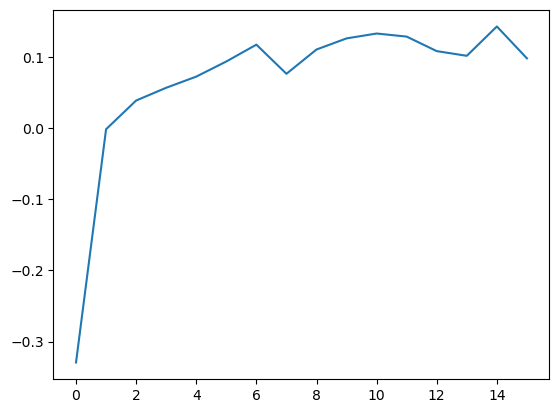

In [75]:
plt.plot(scores)

In [ ]:
subjind = 0
hemisphere = "both"  # lh, rh, or both
areas_to_append = ["FFA-1"] 


areas = []
for area in areas_to_append:
    if hemisphere == "both":
        areas.append('lh_' + area)
        areas.append('rh_' + area)
    elif hemisphere == "lh":
        areas.append('lh_' + area)
    elif hemisphere == "rh":
        areas.append('rh_' + area)

# all_areas = ["V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4", "EBA", "FBA-1", "FBA-2", "mTL-bodies", "OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces", "OPA", "PPA", "RSC", "OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words", "early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal", "all-prf-visual", "all-bodies", "all-faces", "all-places", "all-words", "all-streams"]

brain_target = brainData[0][areas[0]]
for area in areas[1:]:
    brain_target = np.append(brain_target, brainData[0][area],axis=1)

In [25]:
# bestScores = {}
# with open('bestScores.pkl', 'wb') as f:
#     pickle.dump(bestScores, f)

In [ ]:
# A better way

# Load a saved representation

model_names = avail_models
model_names.remove("vit_h_14") #["alexnet", "resnet50", "vit_b_16"]

N_models = len(model_names)

alphas = [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1, 10, 100, 1000, 10000, 1e5, 1e6, 1e7, 1e7]

bestScores_update = {}


for model_name in model_names:
    repDict = {}
    with open('../reps/' + model_name + '_algonauts_shared_images.pkl', 'rb') as f:
        new_reps = pickle.load(f)
        repDict.update(new_reps)
        print("loaded " + model_name)

    # model_names, _ = zip(*repDict.items())
    # model_names = [value for value in repDict.keys()]
    # internal_reps = [value[0] for value in repDict.values()]
    
    
    layer_names = []
    internal_reps = []
    layer_models = []
    
    # for model_name in model_names:
    layer_names.extend([value for value in repDict[model_name].keys()])
    internal_reps.extend([value for value in repDict[model_name].values()])
    layer_models.extend([model_name] * len([value for value in repDict[model_name].keys()]))

    
    # Make sure representations are flattened
    
    internal_reps = [internal_reps[i].reshape((internal_reps[i].shape[0], np.prod(list(internal_reps[i].shape[1:])) )) for i in range(len(internal_reps))]
    
    [internal_rep.shape for internal_rep in internal_reps]

    # Separate into train and test sets

    internal_reps_train = [internal_rep[0:436] for internal_rep in internal_reps]
    internal_reps_test = [internal_rep[436:] for internal_rep in internal_reps]
    brain_target_train = brain_target[0:436]
    brain_target_test = brain_target[436:]

    print(model_name + " prepped")

    scores = []

    for i in range(len(internal_reps)):

        if layer_models[i] == model_name:

            Xtrain = internal_reps_train[i]
            ytrain = brain_target_train

            Xtest = internal_reps_test[i]
            ytest = brain_target_test

            clf = RidgeCV(alphas=alphas).fit(Xtrain, ytrain)
            scores.append(clf.score(Xtest, ytest))
            print(i)
        else:
            continue

    bestind = int(np.argmax(scores))

    bestScores_update[model_name] = [list(repDict[model_name].keys())[bestind], scores[bestind] ]

    with open('bestScores.pkl', 'rb') as f:
        bestScores = pickle.load(f)
        bestScores.update(bestScores_update)

    with open('bestScores.pkl', 'wb') as f:
        pickle.dump(bestScores, f)

    print(model_name + " done")
    
    del repDict


loaded alexnet
alexnet prepped
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
alexnet
loaded convnext_base
convnext_base prepped
0
1
2
3
4
5
6
7
8
9
10
11
convnext_base
loaded convnext_large
convnext_large prepped
0
1
2
3
4
5
6
7
8
9
10
11
convnext_large
loaded convnext_small
convnext_small prepped
0
1
2
3
4
5
6
7
8
9
10
11
convnext_small
loaded convnext_tiny
convnext_tiny prepped
0
1
2
3
4
5
6
7
8
9
10
11
convnext_tiny
loaded densenet121
densenet121 prepped
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
densenet121
loaded densenet161
densenet161 prepped
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
densenet161
loaded densenet169
densenet169 prepped
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
densenet169
loaded densenet201
densenet201 prepped
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
densenet201
loaded efficientnet_b0
efficientnet_b0 prepped
0
1
2
3
4
5
6
7
8
9
10
11
12
efficientnet_b0
loaded efficientnet_b1
efficientnet_b1 prepped
0
1
2
3
4
5
6
7
8
9
10
11
12
efficientnet_b1
loaded efficientnet_b2
efficientnet_b2 prepped
0
1
2
3

In [26]:
with open('bestScores.pkl', 'rb') as f:
    saved_scores = pickle.load(f)

saved_scores

{}